In [1]:
%reload_ext autoreload
%autoreload 2

In [32]:
from fpipe.plot import plot_map as pm
from fpipe.plot import plot_spec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py as h5

import gc

import warnings

from scipy.optimize import leastsq

In [4]:
#def check_tsys(ax, map_path, map_name, freq_diff=False, bin_edge=None):

def profile_fit(ax, h, bc, be, freq_diff=True, bc_min=-0.1, bc_max=0.1, abba=False, threshold=0.5):
    
    h = np.ma.masked_invalid(h)
    good = ~h.mask
    h = np.ma.filled(h, 0)
    if freq_diff:
        good = h > threshold * np.ma.max(h)
        #good = (bc<bc_max) * (bc>bc_min) * (h>0)
    else:
        good = (bc < bc_max) * (h>0)
    if not np.any(good):
        #print np.ma.max(h)
        return 0, 0
    _h = -2 * np.log(h[good])
    _bc= bc[good]
    param = np.polyfit(_bc, _h, 2)
    #print param
    h_fit = np.exp( -0.5 * np.poly1d( param )(bc) )
    
    sigma = np.sqrt(1/param[0])
    b = param[1]/2./param[0]
    A = np.exp(-0.5 * (param[2] - (param[1]**2)/4./param[0]))
    if ax is None:
        return sigma, b
    #label = 'sigma=%f[K], b=%f[K], A=%f'%(sigma, b, A)
    if freq_diff and not abba:
        label = r'$\sigma/\sqrt{2}=%4.3f~[{\rm mK}]$'%(sigma/(2.**0.5) * 1.e3) \
              + '\n' + r'$\mu_0=%4.3f~[{\rm mK}]$'%(b * 1.e3)
    else:
        label = r'$\sigma = %4.3f~[{\rm mK}]$'%(sigma * 1.e3) \
              + '\n' + r'$\mu_0 = %4.3f~[{\rm mK}]$'%(b * 1.e3)
    
    l = ax.plot(bc, h, 'g-', lw=2, drawstyle='steps-mid')[0]
    #plt.plot(bc, h_fit, 'g-')
    ax.plot(bc, A * np.exp(-0.5 * (bc + b)**2/sigma**2), 'r--',
            lw=2, label=label)
    #plt.plot(bc, h, 'r.')
    ax.semilogy()

def check_tsys(ax, m, nfreq, bin_edge=None, freq_diff=True, bc_min=-0.1, bc_max=0.1):

    _m = m.copy()
    #nfreq = float(_m.shape[0])


    _m = _m.flatten()
    mask = _m == 0
    
    if bin_edge is None:
        bs = 0.01
        be = np.arange(-1, 2, bs)
    else:
        be = bin_edge
        bs = be[1] - be[0]
    
    h = np.histogram(_m[~mask], bins=be)[0] / nfreq
    bc = be[:-1] + bs*0.5
    
    del _m, mask
    gc.collect()
    
    if ax is None:
        return h, bc, be

    profile_fit(ax, h, bc, be, freq_diff, bc_min, bc_max)
    

def check_tsys_per_freq(m, nfreq, bin_edge=None):

    _m = m.copy()
    #nfreq = float(_m.shape[0])


    #_m = _m.flatten()
    #mask = _m == 0
    
    if bin_edge is None:
        bs = 0.01
        be = np.arange(-1, 2, bs)
    else:
        be = bin_edge
        bs = be[1] - be[0]
        
    hist = []
    for i in range(_m.shape[0]):
        mask = _m[i] == 0
        hist.append(np.histogram(_m[i][~mask], bins=be)[0][None, :])
    bc = be[:-1] + bs*0.5
    hist = np.concatenate(hist, axis=0)
    
    
    del _m, mask
    gc.collect()
    
    return hist, bc, be


In [5]:
def check_tsys_group_map(map_path, map_prefix_list, map_cent_list, map_freq, freq_diff, 
                     figsize=(6, 8), ylabel_list=None, freq_sel=slice(0, None), hit_freq_list=None):
    
    name_tmp = '%s_%s_%s_vis.h5'
    
    if freq_diff:
        bin_edges = np.linspace(-0.49, 0.49, 100)
    else:
        bin_edges = np.arange(-1, 2, 0.01)
        
    if ylabel_list is None:
        ylabel_list = ['N', ] * len(map_prefix_list)
        
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(len(map_prefix_list), len(map_cent_list), left=0.055, bottom=0.045,
                           right=0.98, top=0.95, wspace=0.02, hspace=0.02)
    
    for jj, map_prefix in enumerate(map_prefix_list):
        for ii, map_cent in enumerate(map_cent_list):
            
            map_name = name_tmp%(map_prefix, map_cent, map_freq)
            #print map_name
            ax = fig.add_subplot(gs[jj, ii])
            
            m = pm.load_maps_hp(map_path, map_name, 'clean_map')[0]
            
            mask = m == 0
            
            if hit_freq_list is not None:
                hit_freq = hit_freq_list[ii, jj]
                #print hit_freq.shape
                #print m.shape
                #print np.sum(hit_freq >= 18), hit_freq.shape[0]
                mask += hit_freq[:, None] < 18
                
            if freq_diff:
                m    = m[1:, :]    - m[:-1, :]
                mask = mask[1:, :] + mask[:-1, :]
            m[mask] = 0
            


            m = m[freq_sel, ...]
            nfreq = m.shape[0]
            check_tsys(ax, m, nfreq, bin_edges, bc_min=-0.05, bc_max=0.05)
            if ii == 0:
                ax.set_ylabel(ylabel_list[jj])
            else:
                ax.set_yticklabels([])
            if jj == len(map_prefix_list) - 1:
                ax.set_xlabel('T [K]')
            else:
                ax.set_xticklabels([])

            ax.set_xlim(-0.46, 0.46)
            #ax.set_ylabel('N')
            ax.legend(loc=1) 
            title='%s %s \n %s'%tuple(map_cent.split('_'))
            if jj == 0:
                ax.set_title(title)
            ax.set_ylim(ymin=5e-2, ymax=2.e3)
            
    #fig.savefig('output/map_rms_hist.png', dpi=200)
    
    

In [6]:
def rms_AB(m, mask):
    m    = m[1:, :]    - m[:-1, :]
    mask = mask[1:, :] + mask[:-1, :]
    m[mask] = 0
    return m, mask

def rms_AB_tod_old(m, mask):
    m    = m[:, 1:, :]    - m[:, :-1, :]
    mask = mask[:, 1:, :] + mask[:, :-1, :]
    m[mask] = 0
    return m, mask


def rms_AB_tod(m, mask):
    #m    = m[:, 1:, :]    - m[:, :-1, :]
    #mask = mask[:, 1:, :] + mask[:, :-1, :]
    
    freq_l = m.shape[1]/2 * 2
    m      = m[:, :freq_l, :]
    mask   = mask[:, :freq_l, :]
    shp = m.shape
    m.shape = ( shp[0], -1, 2, shp[-1])
    m = m[:, :, 0, :] - m[:, :, 1, :]
    
    mask.shape = ( shp[0], -1, 2, shp[-1] )
    mask = mask[:, :, 0, :] + mask[:, :, 1, :]
    
    print m.shape
    m[mask] = 0
    return m, mask

def rms_ABBA_tod(m, mask):
    #m    = m[:, 1:, :]    - m[:, :-1, :]
    #mask = mask[:, 1:, :] + mask[:, :-1, :]
    
    freq_l = m.shape[1]/4 * 4
    m      = m[:, :freq_l, :]
    mask   = mask[:, :freq_l, :]
    shp = m.shape
    m.shape = ( shp[0], -1, 4, shp[-1])
    m = 0.5 * ( m[:, :, 1, :] + m[:, :, 2, :] ) - 0.5 * ( m[:, :, 0, :] + m[:, :, 3, :] )
    
    mask.shape = ( shp[0], -1, 4, shp[-1] )
    mask = mask[:, :, 0, :] + mask[:, :, 1, :] + mask[:, :, 2, :] + mask[:, :, 3, :]
    
    #print m.shape
    m[mask] = 0
    return m, mask

def rms_ABBA_map(m, mask):

    freq_l = m.shape[0]/4 * 4
    m      = m[:freq_l, :]
    mask   = mask[:freq_l, :]
    shp = m.shape
    m.shape = (-1, 4, shp[-1])
    m = 0.5 * ( m[:, 1, :] + m[:, 2, :] ) - 0.5 * ( m[:, 0, :] + m[:, 3, :] )
    
    mask.shape = (-1, 4, shp[-1] )
    mask = mask[:, 0, :] + mask[:, 1, :] + mask[:, 2, :] + mask[:, 3, :]
    
    #print m.shape
    m[mask] = 0
    return m, mask

In [7]:
def check_tsys_group_map_combine(map_path, map_prefix_list, map_cent_list, map_freq, freq_diff, 
                     figsize=None, ylabel_list=None, freq_sel=slice(0, None), hit_freq_list=None):
    
    name_tmp = '%s_%s_%s_vis.h5'
    
    if freq_diff:
        bin_edges = np.linspace(-0.49, 0.49, 100)
    else:
        bin_edges = np.arange(-1, 2, 0.01)
        
    if ylabel_list is None:
        ylabel_list = ['N', ] * len(map_prefix_list)
    
    hist_list = []

    for jj, map_prefix in enumerate(map_prefix_list):
        for ii, map_cent in enumerate(map_cent_list):
            
            map_name = name_tmp%(map_prefix, map_cent, map_freq)
            
            m = pm.load_maps_hp(map_path, map_name, 'clean_map')[0]
            
            mask = m == 0
            
            if hit_freq_list is not None:
                hit_freq = hit_freq_list[ii, jj]
                print np.sum(hit_freq[:, None] < 18), hit_freq.shape[0]
                mask += hit_freq[:, None] < 18
                
            if freq_diff:
                m, mask = rms_ABBA_map(m, mask)

            m = m[freq_sel, ...]
            nfreq = m.shape[0]
            h, bc, be = check_tsys(None, m, nfreq, bin_edges, bc_min=-0.05, bc_max=0.05)
            hist_list.append(h[None, :])
    hist = np.concatenate(hist_list, axis=0)
    
    if figsize is None:
        return hist, bc, be
    
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_axes([0.12, 0.12, 0.83, 0.83])
    
    for i in range(hist.shape[0]):
        ax.plot(bc, hist[i] / np.sum(hist[i] * 1.), color='0.7', lw=0.5, drawstyle='steps-mid')
        
    hist_tot = np.sum(hist, axis=0)
    ax.plot(bc, hist_tot / np.sum(hist_tot * 1.), 'k-', lw=2, drawstyle='steps-mid')
    
    
    profile_fit(ax, hist_tot / np.sum(hist_tot * 1.), bc, be, freq_diff=True, bc_min=-0.1, bc_max=0.1, abba=True)
    
    ax.legend()
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(2.e-4, 1.e-1)
    #ax.tick_params(axis='y', labelrotation= 90)
    ax.set_xlabel('T [K]')
    ax.set_ylabel('N')
    ax.semilogy()
    fig.savefig('output/map_rms_hist_combine.png', dpi=200)
    
def check_tsys_one_combined_map(map_path, map_name, freq_diff, 
                     figsize=None, ylabel_list=None, freq_sel=slice(0, None), hit_freq_list=None):

    if freq_diff:
        bin_edges = np.linspace(-0.49, 0.49, 100)
    else:
        bin_edges = np.arange(-1, 2, 0.01)
        
    if ylabel_list is None:
        ylabel_list = ['N', ] * len(map_prefix_list)

    m = pm.load_maps_hp(map_path, map_name, 'clean_map')[0]
            
    mask = m == 0
    
    if hit_freq_list is not None:
        hit_freq = hit_freq_list[ii, jj]
        print np.sum(hit_freq[:, None] < 18), hit_freq.shape[0]
        mask += hit_freq[:, None] < 18
        
    if freq_diff:
        m, mask = rms_ABBA_map(m, mask)

    m = m[freq_sel, ...]
    nfreq = m.shape[0]
    hist, bc, be = check_tsys(None, m, nfreq, bin_edges, bc_min=-0.05, bc_max=0.05)

    if figsize is None:
        return hist, bc, be
    
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_axes([0.12, 0.12, 0.83, 0.83])
    
    for i in range(hist.shape[0]):
        ax.plot(bc, hist[i] / np.sum(hist[i] * 1.), color='0.7', lw=0.5, drawstyle='steps-mid')
        
    hist_tot = np.sum(hist, axis=0)
    ax.plot(bc, hist_tot / np.sum(hist_tot * 1.), 'k-', lw=2, drawstyle='steps-mid')
    
    
    profile_fit(ax, hist_tot / np.sum(hist_tot * 1.), bc, be, freq_diff=True, bc_min=-0.1, bc_max=0.1, abba=True)
    
    ax.legend()
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(2.e-4, 1.e-1)
    #ax.tick_params(axis='y', labelrotation= 90)
    ax.set_xlabel('T [K]')
    ax.set_ylabel('N')
    ax.semilogy()
    fig.savefig('output/map_rms_hist_combine.png', dpi=200)
    
def check_tsys_one_combined_map_freq_by_freq(map_path, map_name, freq_diff, 
                                             freq_sel=slice(0, None), hit_freq_list=None):

    if freq_diff:
        bin_edges = np.linspace(-0.49, 0.49, 100)
    else:
        bin_edges = np.arange(-1, 2, 0.01)

    m = pm.load_maps_hp(map_path, map_name, 'clean_map')[0]
            
    mask = m == 0
    
    if hit_freq_list is not None:
        hit_freq = hit_freq_list[ii, jj]
        print np.sum(hit_freq[:, None] < 18), hit_freq.shape[0]
        mask += hit_freq[:, None] < 18
        
    if freq_diff:
        m, mask = rms_ABBA_map(m, mask)

    m = m[freq_sel, ...]
    nfreq = m.shape[0]
    hist, bc, be = check_tsys_per_freq(m, nfreq, bin_edges)

    return hist, bc, be

In [8]:
def check_tsys_group_tod(tod_path, tod_suffix_list, tod_cent_list, tod_freq, freq_diff, 
                     figsize=(6, 8), ylabel_list=None, freq_sel = slice(0, None)):
    
    tod_tmp = '%s_%s_%s.h5'
    
    if freq_diff:
        bin_edges = np.linspace(-0.6, 0.6, 100)
    else:
        bin_edges = np.arange(-1, 2, 0.01)
        
    if ylabel_list is None:
        ylabel_list = ['N', ] * len(tod_prefix_list)
        
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(len(tod_suffix_list), len(tod_cent_list), left=0.055, bottom=0.045,
                           right=0.98, top=0.95, wspace=0.02, hspace=0.02)
    
    for jj, tod_suffix in enumerate(tod_suffix_list):
        for ii, tod_cent in enumerate(tod_cent_list):
            tod_name = tod_tmp%(tod_cent, tod_suffix, tod_freq)
            #print tod_name
            ax = fig.add_subplot(gs[jj, ii])
            
            #m = pm.load_maps_hp(map_path, map_name, 'clean_map')[0]
            with h5.File(tod_path + tod_name, 'r') as f:
                m = f['vis'][:]
                mask = f['vis_mask'][:].astype('bool')
                ns_on = f['ns_on'][:].astype('bool')
            
            mask += ns_on[:, None, None, :]

            m[mask] = 0
            m = np.sum(m, axis=2) / 2.
            mask = m == 0

            if freq_diff:
                m = m[:, 1:, :] - m[:, :-1, :]
                mask = mask[:, 1:, :] + mask[:, :-1, :]
            m[mask] = 0
            m = m[:, freq_sel, 0]
            nfreq = m.shape[1]
            check_tsys(ax, m, nfreq, bin_edges, bc_min=-1, bc_max=1)
            if ii == 0:
                ax.set_ylabel(ylabel_list[jj])
            else:
                ax.set_yticklabels([])
            if jj == len(tod_suffix_list) - 1:
                ax.set_xlabel('T [K]')
            else:
                ax.set_xticklabels([])

            ax.set_xlim(-0.6, 0.6)
            #ax.set_xlim(-1, 1)
            #ax.set_ylabel('N')
            ax.legend(loc=1) 
            #title='%s %s \n %s'%tuple(map_cent.split('_'))
            #if jj == 0:
            #    ax.set_title(title)
            ax.set_ylim(ymin=1.e0, ymax=2.e2)

            
    #fig.savefig('output/map_rms_hist.png', dpi=200)

In [9]:
def rms_ABBA(m, mask):
    
    m    = m[1:, :]    - m[:-1, :]
    mask = mask[1:, :] + mask[:-1, :]
    m[mask] = 0
    return m, mask

In [10]:
def check_tsys_group_tod_combine(tod_path, tod_suffix_list, tod_cent_list, tod_freq, freq_diff, 
                     figsize=None, ylabel_list=None, freq_sel = slice(0, None)):
    
    tod_tmp = '%s_%s_%s.h5'
    
    if freq_diff:
        bin_edges = np.linspace(-0.6, 0.6, 100)
    else:
        bin_edges = np.arange(-1, 2, 0.01)
        
    if ylabel_list is None:
        ylabel_list = ['N', ] * len(tod_prefix_list)

    hist_list = []
    for jj, tod_suffix in enumerate(tod_suffix_list):
        for ii, tod_cent in enumerate(tod_cent_list):
            tod_name = tod_tmp%(tod_cent, tod_suffix, tod_freq)

            with h5.File(tod_path + tod_name, 'r') as f:
                m = f['vis'][:]
                mask = f['vis_mask'][:].astype('bool')
                ns_on = f['ns_on'][:].astype('bool')
            
            mask += ns_on[:, None, None, :]

            m[mask] = 0
            m = np.sum(m, axis=2) / 2.
            mask = m == 0

            if freq_diff:
                #m, mask = rms_AB_tod(m, mask)
                m, mask = rms_ABBA_tod(m, mask)
            m[mask] = 0
            m = m[:, freq_sel, :]
            nfreq = m.shape[1]
            for beam in range(19):
                h, bc, be = check_tsys(None, m[:, :, beam], nfreq, bin_edges, bc_min=-1, bc_max=1)
                hist_list.append(h[None, :])

    hist = np.concatenate(hist_list, 0)
    if figsize is None:
        return hist, bc, be

    fig = plt.figure(figsize=figsize)
    ax  = fig.add_axes([0.12, 0.12, 0.83, 0.83])
    
    for i in range(hist.shape[0]):
        ax.plot(bc, hist[i] / np.sum(hist[i] * 1.), color='0.7', lw=0.5, drawstyle='steps-mid')
        
    hist_tot = np.sum(hist, axis=0)
    ax.plot(bc, hist_tot / np.sum(hist_tot * 1.), 'k-', lw=2, drawstyle='steps-mid')
    
    
    profile_fit(ax, hist_tot / np.sum(hist_tot * 1.), bc, be, freq_diff=True, 
                bc_min=-0.3, bc_max=0.3, abba=True)
    
    ax.legend()
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(2.e-4, 1.e-1)
    #ax.tick_params(axis='y', labelrotation= 90)
    ax.set_xlabel('T [K]')
    ax.set_ylabel('N')
    ax.semilogy()
    #fig.savefig('output/map_rms_hist_combine.png', dpi=200)


In [58]:
from fpipe.timestream import data_base as DB
data_dict = DB.DATA_BASE

In [60]:
for k in data_dict.keys():
    print k, data_dict[k]['BAD_FEED']

20210302 [6, 10]
20210314 [10]
20210306 [9, 10]
20210307 []
20210313 [6]
20210305 [6, 10]
20210309 [10, 17]


In [61]:
def iter_tod(file_root, file_name_list, freq_band = '1250-1450MHz', bad_list=None):
    
    for ff, file_name in enumerate( file_name_list ):
        file_list = [file_root + '%s_arcdrift%04d-%04d_%s.h5'%(file_name, i, i, freq_band)
                     for i in range(1, 8)]
        for name in file_list:
            with h5.File(name, 'r') as f:
                #_ra.append(f['ra'][:])
                #_dec.append(f['dec'][:])
                #_on.append(f['ns_on'][:])
                #ra  = f['ra'][:]
                #dec = f['dec'][:]
                ns_on = f['ns_on'][:]
                freq = f['freq'][:]
                mask  = f['vis_mask'][:].astype('bool')
                mask += ns_on[:, None, None, :]
                #time = Time(f['sec1970'][:], format='unix')
            if bad_list is not None:
                for b in bad_list[ff]:
                    print b-1
                    mask[:, :, :, b-1] = True
            yield name, mask, freq
            
file_root = '/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/'
file_name_list = ['20210314/HIMGS_1100+2610',
                  '20210302/HIMGS_1100+2600', '20210305/HIMGS_1100+2632', 
                  '20210306/HIMGS_1100+2643', '20210307/HIMGS_1100+2654', 
                  '20210309/HIMGS_1100+2610', '20210313/HIMGS_1100+2621', 
                  ]
bad_beam_list = [[10,], 
                 [6, 10], [6, 10],
                 [9, 10], [],
                 [10, 17], [6,]
                ]

hit_freq_list_h = []
for tod in iter_tod(file_root, file_name_list, freq_band='1250-1450MHz', bad_list=bad_beam_list):
    name, mask, freq_h = tod
    hit_freq_list_h.append( ( np.sum((~mask).astype('uint'), axis=(0, 2, 3)) / 2.)[None, :] )
hit_freq_list_h = np.concatenate(hit_freq_list_h, axis=0)


hit_freq_list_l = []
for tod in iter_tod(file_root, file_name_list, freq_band='1050-1150MHz', bad_list=bad_beam_list):
    name, mask, freq_l = tod
    hit_freq_list_l.append( ( np.sum((~mask).astype('uint'), axis=(0, 2, 3)) / 2.)[None, :] )
hit_freq_list_l = np.concatenate(hit_freq_list_l, axis=0)

9
9
9
9
9
9
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
8
9
8
9
8
9
8
9
8
9
8
9
8
9
9
16
9
16
9
16
9
16
9
16
9
16
9
16
5
5
5
5
5
5
5
9
9
9
9
9
9
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
5
9
8
9
8
9
8
9
8
9
8
9
8
9
8
9
9
16
9
16
9
16
9
16
9
16
9
16
9
16
5
5
5
5
5
5
5


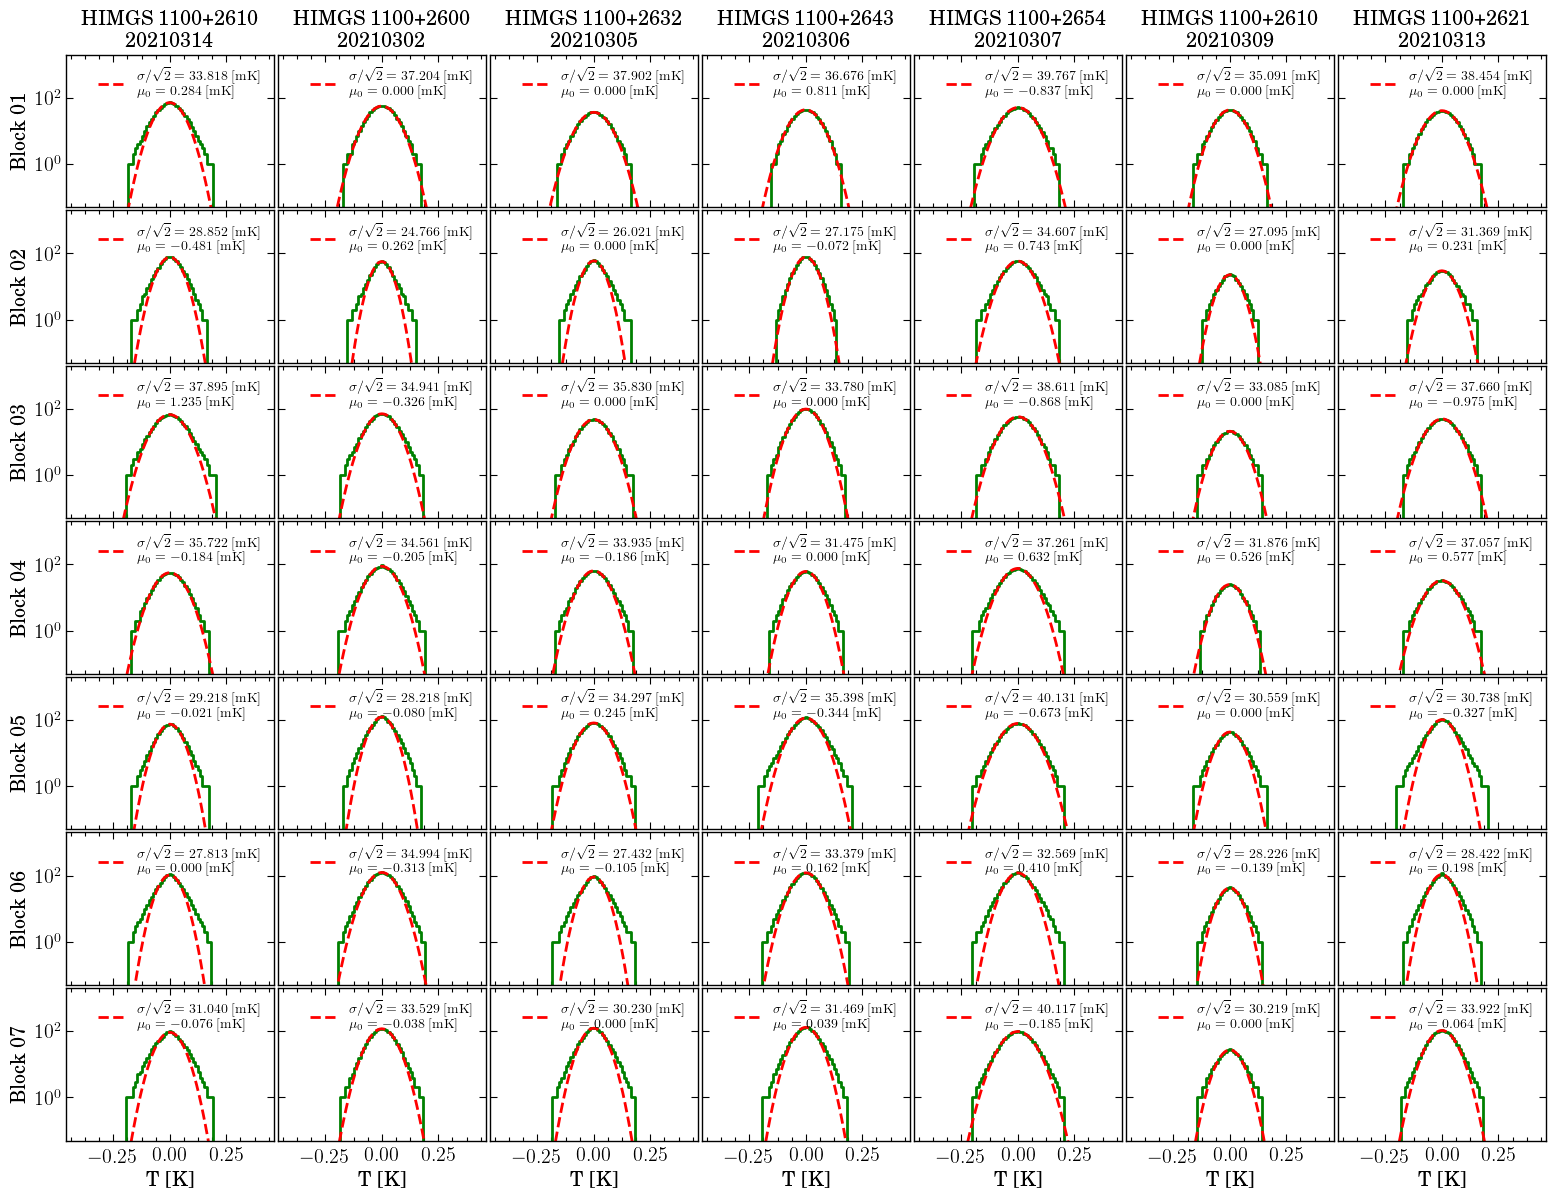

In [25]:
map_path = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC_centeronly/'

figsize = (16, 12)

ylabel_list = ['Block 01', 'Block 02', 'Block 03', 'Block 04', 'Block 05', 'Block 06', 'Block 07']
map_prefix_list = ['cm_00', 'cm_01', 'cm_02', 'cm_03', 'cm_04', 'cm_05', 'cm_06']
map_freq = '1050-1150MHz'
map_cent_list = ['HIMGS_1100+2610_20210314', 
                 'HIMGS_1100+2600_20210302', 'HIMGS_1100+2632_20210305',
                 'HIMGS_1100+2643_20210306', 'HIMGS_1100+2654_20210307',
                 'HIMGS_1100+2610_20210309', 'HIMGS_1100+2621_20210313',
                 
                 ]

norm = 86897
check_tsys_group_map(map_path, map_prefix_list, map_cent_list, map_freq, True, 
                     figsize, ylabel_list=ylabel_list, freq_sel = slice(0, None),
                     hit_freq_list=hit_freq_list_l.reshape([7, 7, -1])/( norm / 49.))

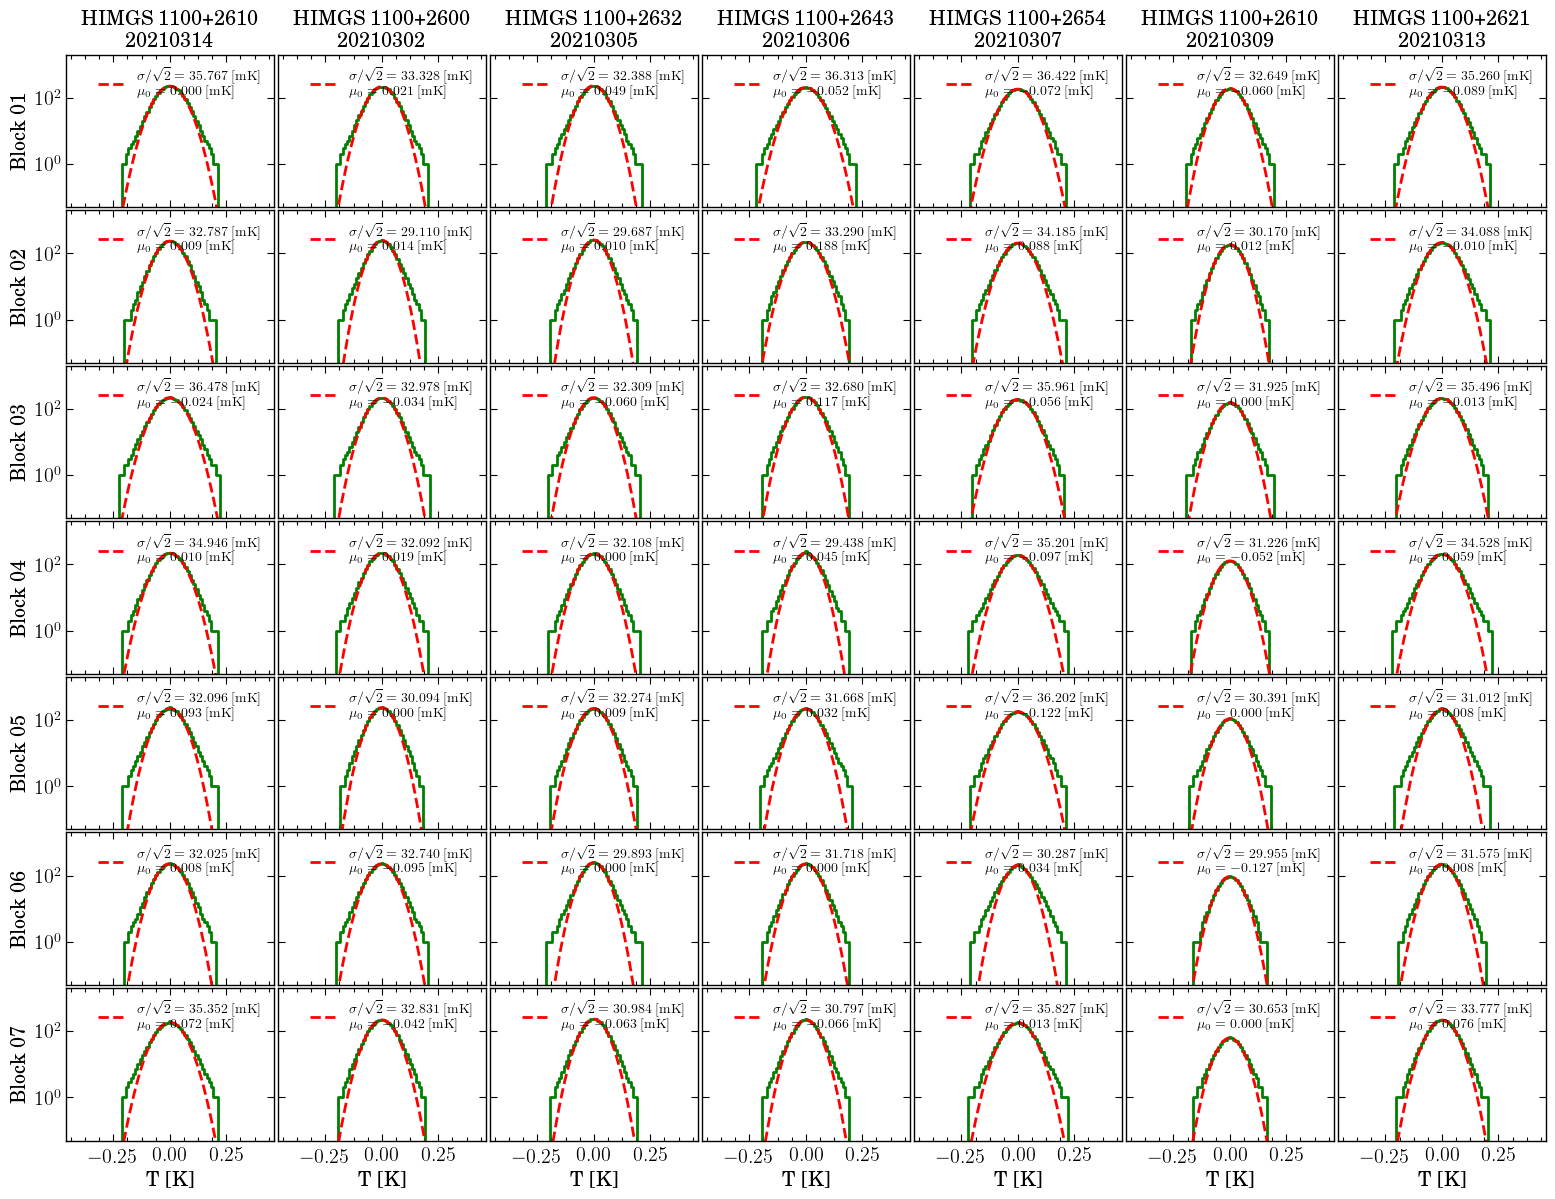

In [19]:
map_path = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC_centeronly/'

figsize = (16, 12)

ylabel_list = ['Block 01', 'Block 02', 'Block 03', 'Block 04', 'Block 05', 'Block 06', 'Block 07']
map_prefix_list = ['cm_00', 'cm_01', 'cm_02', 'cm_03', 'cm_04', 'cm_05', 'cm_06']
map_freq = '1250-1450MHz'
map_cent_list = ['HIMGS_1100+2610_20210314', 
                 'HIMGS_1100+2600_20210302', 'HIMGS_1100+2632_20210305',
                 'HIMGS_1100+2643_20210306', 'HIMGS_1100+2654_20210307',
                 'HIMGS_1100+2610_20210309', 'HIMGS_1100+2621_20210313',
                 
                 ]

norm = 86897
check_tsys_group_map(map_path, map_prefix_list, map_cent_list, map_freq, True, 
                     figsize, ylabel_list=ylabel_list, freq_sel = slice(0, None),
                     hit_freq_list=hit_freq_list_h.reshape([7, 7, -1])/( norm / 49.))

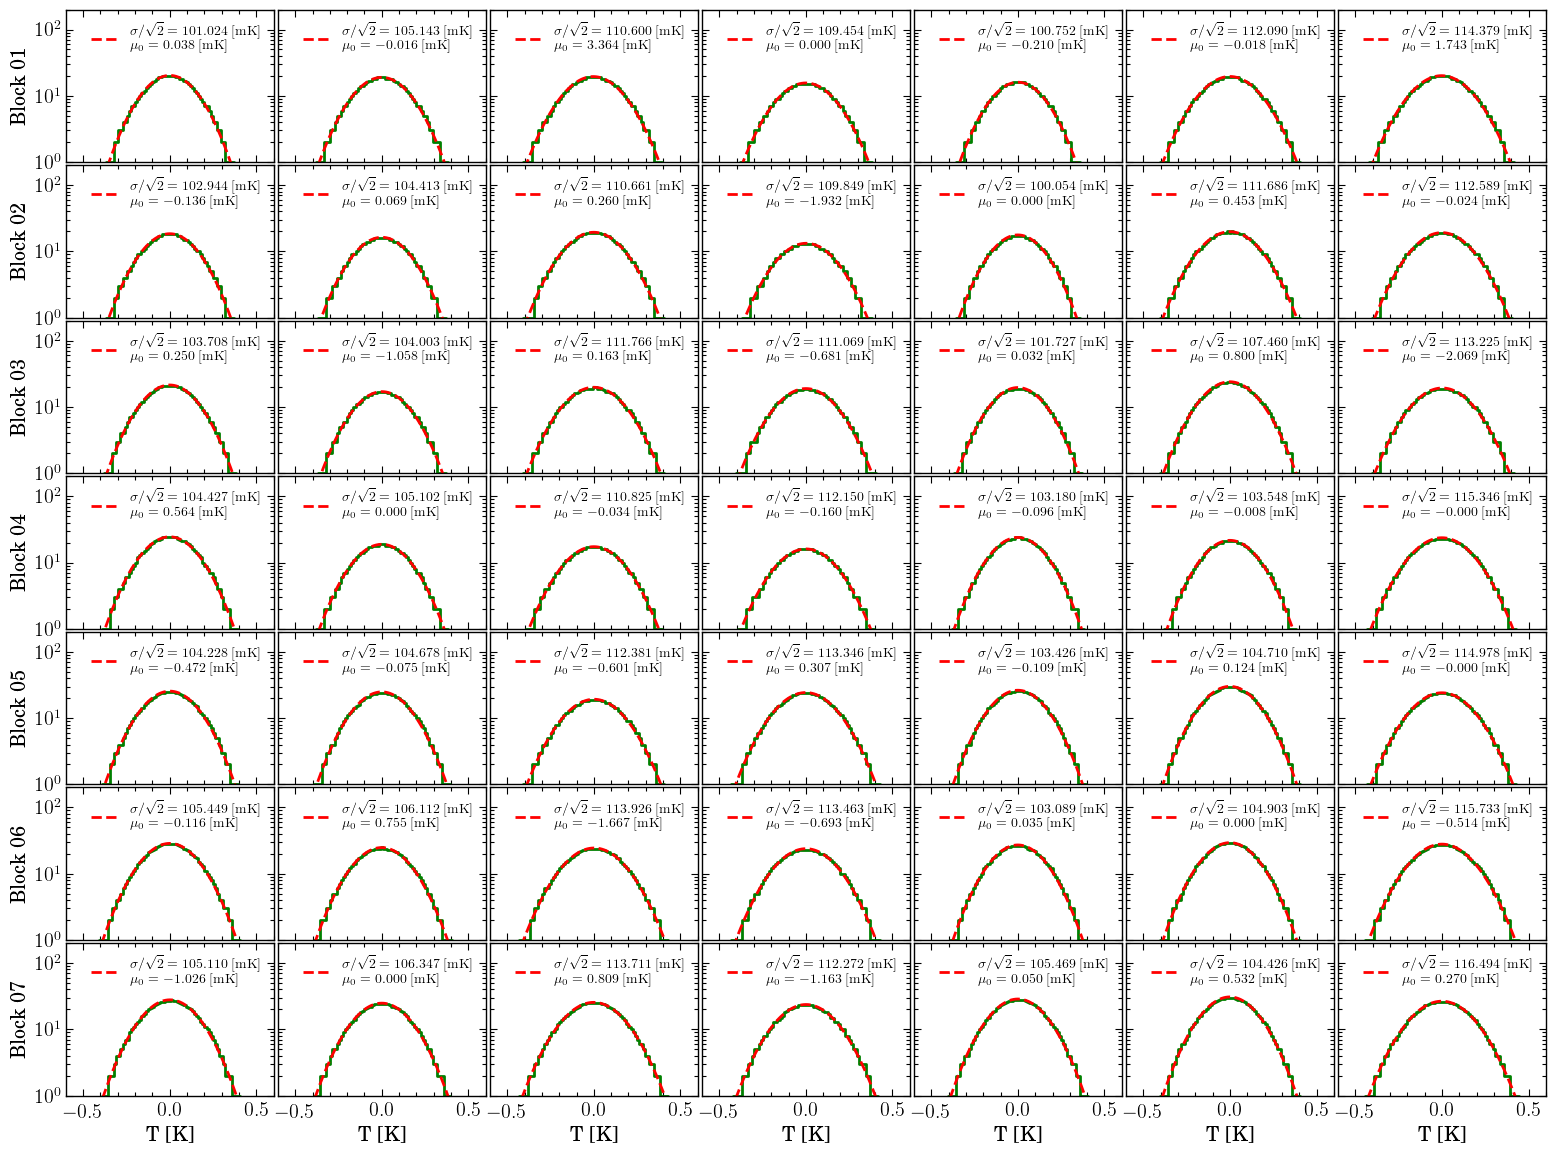

In [62]:
tod_path = '/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/'

#tod_path = '/scratch3/users/ycli/fanalysis/rb4_etaA_sumfeeds_CC/'
freq_diff = True
figsize = (16, 12)

ylabel_list = ['Block 01', 'Block 02', 'Block 03', 'Block 04', 'Block 05', 'Block 06', 'Block 07']
tod_suffix_list = ['arcdrift%04d-%04d'%(i+1, i+1) for i in range(7)]
tod_freq = '1050-1150MHz'
tod_cent_list = ['20210302/HIMGS_1100+2600', 
                 '20210309/HIMGS_1100+2610',
                 '20210314/HIMGS_1100+2610',
                 '20210313/HIMGS_1100+2621',
                 '20210305/HIMGS_1100+2632',
                 '20210306/HIMGS_1100+2643',
                 '20210307/HIMGS_1100+2654',
                 ] 


check_tsys_group_tod(tod_path, tod_suffix_list, tod_cent_list, tod_freq, freq_diff, 
                     figsize=figsize, ylabel_list=ylabel_list, freq_sel=slice(0, None))

In [120]:
tod_path = '/scratch3/users/ycli/fanalysis/rb4_rmbsl_sumfeeds_CC/'

#tod_path = '/scratch3/users/ycli/fanalysis/rb4_etaA_sumfeeds_CC/'
freq_diff = True
figsize = (6, 4)

ylabel_list = ['Block 01', 'Block 02', 'Block 03', 'Block 04', 'Block 05', 'Block 06', 'Block 07']
tod_suffix_list = ['arcdrift%04d-%04d'%(i+1, i+1) for i in range(7)]
tod_cent_list = ['20210302/HIMGS_1100+2600', 
                 '20210309/HIMGS_1100+2610',
                 '20210314/HIMGS_1100+2610',
                 '20210313/HIMGS_1100+2621',
                 '20210305/HIMGS_1100+2632',
                 '20210306/HIMGS_1100+2643',
                 '20210307/HIMGS_1100+2654',
                 ] 

tod_freq = '1050-1150MHz'
hist_tod_l, bc_l, be_l = check_tsys_group_tod_combine(tod_path, tod_suffix_list, 
                                                      tod_cent_list, tod_freq, freq_diff, 
                                                      figsize=None, ylabel_list=ylabel_list, 
                                                      freq_sel=slice(0, None))

tod_freq = '1250-1450MHz'
hist_tod_h, bc_h, be_h = check_tsys_group_tod_combine(tod_path, tod_suffix_list, 
                                                      tod_cent_list, tod_freq, freq_diff, 
                                                      figsize=None, ylabel_list=ylabel_list, 
                                                      freq_sel=slice(0, None))

In [127]:
hist_tod_l = np.concatenate(hist_tod_l, axis=0)
hist_tod_h = np.concatenate(hist_tod_h, axis=0)

In [133]:
hist_tod_l.shape = (49, 19, -1)
hist_tod_h.shape = (49, 19, -1)

In [15]:
from fpipe.utils import axes_utils

def plot_rms_all_beam(hist_tod_l, bc):

    fig, axes = axes_utils.setup_axes(m=4, n=5, colorbar=False, title='')
    for i in range(19):
        ax = axes[i]
        for j in range(49):
            
            ax.plot(bc, hist_tod_l[j, i] / np.sum(hist_tod_l[j, i] * 1.), color='0.7', 
                    lw=0.5, drawstyle='steps-mid')
            
        hist_tot = np.sum(hist_tod_l[:, i], axis=0)
        #ax.plot(bc, hist_tot / np.sum(hist_tot * 1.), 'k-', lw=2, drawstyle='steps-mid')
        
        profile_fit(ax, hist_tot / np.sum(hist_tot * 1.), bc, be, freq_diff=True, 
                    bc_min=-0.15, bc_max=0.15, abba=True)
    
        ax.legend(loc=8)
        ax.set_xlim(-0.4, 0.4)
        ax.set_ylim(2.e-4, 9.e-2)
        #ax.tick_params(axis='y', labelrotation= 90)
        
        ii = i / 5
        jj = i - ii * 5
        if ii == 3:
            ax.set_xlabel('T [K]')
        else:
            ax.set_xticklabels([])
        
        if jj == 0:
            ax.set_ylabel('N')
        else:
            ax.set_yticklabels([])
        

In [145]:
map_path = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC_centeronly/'

figsize = (6, 4)

ylabel_list = ['Block 01', 'Block 02', 'Block 03', 'Block 04', 'Block 05', 'Block 06', 'Block 07']
map_prefix_list = ['cm_00', 'cm_01', 'cm_02', 'cm_03', 'cm_04', 'cm_05', 'cm_06']

map_cent_list = ['HIMGS_1100+2610_20210314', 
                 'HIMGS_1100+2600_20210302', 'HIMGS_1100+2632_20210305',
                 'HIMGS_1100+2643_20210306', 'HIMGS_1100+2654_20210307',
                 'HIMGS_1100+2610_20210309', 'HIMGS_1100+2621_20210313',
                 
                 ]

norm = 86897

map_freq = '1050-1150MHz'
hist_map_l, bc_map_l, be_map_l = check_tsys_group_map_combine(map_path, map_prefix_list, map_cent_list, map_freq, True, 
                     figsize=None, ylabel_list=ylabel_list, freq_sel = slice(0, None),
                     hit_freq_list=hit_freq_list_l.reshape([7, 7, -1])/( norm / 49.))


map_freq = '1250-1450MHz'
hist_map_h, bc_map_h, be_map_h = check_tsys_group_map_combine(map_path, map_prefix_list, map_cent_list, map_freq, True, 
                     figsize=None, ylabel_list=ylabel_list, freq_sel = slice(0, None),
                     hit_freq_list=hit_freq_list_h.reshape([7, 7, -1])/( norm / 49.))

In [40]:
def plot_rms_hist_low_and_high_band(hist_map_l, hist_map_h, bc_map_l, bc_map_h, be_map_l, be_map_h, 
                                    xlim=(-0.19, 0.19), ylim=(2.e-4, 1.5e-1), output_name='test.png'):
    
    fig = plt.figure(figsize=(6, 4))
    ax_l  = fig.add_axes([0.12, 0.12, 0.41, 0.83])
    ax_h  = fig.add_axes([0.54, 0.12, 0.41, 0.83])
    
    r_l_list = []
    for i in range(hist_map_l.shape[0]):
        ax_l.plot(bc_map_l, hist_map_l[i] / np.sum(hist_map_l[i] * 1.), color='0.7', lw=0.5, drawstyle='steps-mid')
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                r_l_list.append( profile_fit(None, hist_map_l[i] / np.sum(hist_map_l[i] * 1.), bc_map_l, be_map_l) )
            except:
                r_l_list.append([0, 0])
            
    hist_tot = np.sum(hist_map_l, axis=0)
    profile_fit(ax_l, hist_tot / np.sum(hist_tot * 1.), bc_map_l, be_map_l, freq_diff=True, 
                bc_min=-0.05, bc_max=0.05, abba=True)
    
    r_h_list = []
    for i in range(hist_map_h.shape[0]):
        ax_h.plot(bc_map_h, hist_map_h[i] / np.sum(hist_map_h[i] * 1.), color='0.7', lw=0.5, drawstyle='steps-mid')
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                r_h_list.append(profile_fit(None, hist_map_h[i] / np.sum(hist_map_h[i] * 1.),  bc_map_h, be_map_h))
            except:
                r_h_list.append([0, 0])
                
    hist_tot = np.sum(hist_map_h, axis=0)
    profile_fit(ax_h, hist_tot / np.sum(hist_tot * 1.), bc_map_h, be_map_h, freq_diff=True, 
                bc_min=-0.05, bc_max=0.05, abba=True)
    
    ax_l.legend(title='1050-1150 MHz')
    ax_l.set_xlim(*xlim)
    ax_l.set_ylim(*ylim)
    ax_l.set_xlabel('T [K]')
    ax_l.set_ylabel('N')
    ax_l.semilogy()
    
    
    ax_h.semilogy()
    ax_h.legend(title='1323-1150 MHz')
    ax_h.set_yticklabels([])
    ax_h.set_xlabel('T [K]')
    ax_h.set_xlim(*xlim)
    ax_h.set_ylim(*ylim)
    
    r_l_list = np.array(r_l_list)
    r_h_list = np.array(r_h_list)
    
    fig.savefig('output/' + output_name, dpi=200)
    return r_l_list, r_h_list
    


In [165]:
map_path = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC_centeronly/'


norm = 86897 # number of pixsels in the field

map_name = 'Combined_1050-1150MHz.h5'
hist_map1_l, bc_map1_l, be_map1_l = check_tsys_one_combined_map(map_path, map_name, True, 
                     figsize=None, ylabel_list=ylabel_list, freq_sel = slice(0, None),
                     hit_freq_list=hit_freq_list_l.reshape([7, 7, -1])/( norm / 49.))


map_name = 'Combined_1250-1450MHz.h5'
hist_map1_h, bc_map1_h, be_map1_h = check_tsys_one_combined_map(map_path, map_name, True,  
                     figsize=None, ylabel_list=ylabel_list, freq_sel = slice(0, None),
                     hit_freq_list=hit_freq_list_h.reshape([7, 7, -1])/( norm / 49.))

2601 3276
1546 4153


In [12]:
map_path = '/scratch3/users/ycli/fanalysis/map_df28k_sumfeeds_CC_centeronly/'
norm = 86897

map_name = 'Combined_1050-1150MHz.h5'
hist_map1_l_fbf, bc_map1_l_fbf, be_map1_l_fbf = check_tsys_one_combined_map_freq_by_freq(
    map_path, map_name, freq_diff=True, freq_sel=slice(0, None))

map_name = 'Combined_1250-1450MHz.h5'
hist_map1_h_fbf, bc_map1_h_fbf, be_map1_h_fbf = check_tsys_one_combined_map_freq_by_freq(
    map_path, map_name, freq_diff=True, freq_sel=slice(0, None))

/users/ycli/code/fpipe/fpipe/map/algebra.py:1044: UserWarning: Initialization argument ignored. Requisite metadata for vector already exists. Clear info dictionary if you want opposite behaviour.
  warnings.warn("Initialization argument ignored. Requisite "


/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


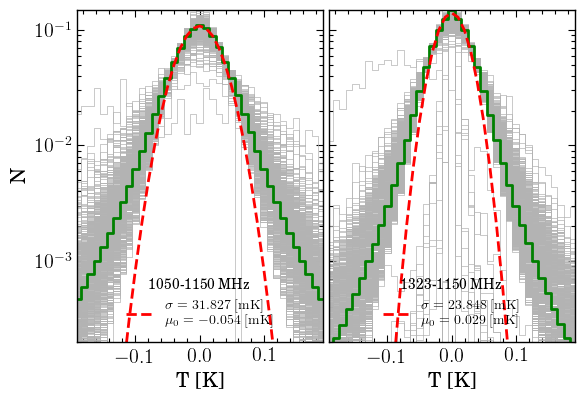

In [41]:
sigma_freq_l_list, sigma_freq_h_list = plot_rms_hist_low_and_high_band(hist_map1_l_fbf, 
                                                                       hist_map1_h_fbf, 
                                                                       bc_map1_l_fbf, 
                                                                       bc_map1_h_fbf,
                                                                       be_map1_l_fbf,
                                                                       be_map1_h_fbf,
                                                                       output_name='map_rms_hist_combine.png')

In [63]:
def get_N_rebin(hit_freq, factor):
    
    # get N of combined 4 frequency channels
    
    
    # N = (N1 + N2 + N3 + N4) / 4
    #hit_freq = np.mean(hit_freq.reshape((-1, 4)), axis=1) * factor
    
    # 1/N = (1/N1 + 1/N2 + 1/N3 + 1/N4) / 4
    #hit_freq = hit_freq.reshape((-1, 4))
    #hit_freq = hit_freq * factor
    #hit_freq[hit_freq==0] = np.inf
    #hit_freq = np.mean(1./hit_freq , axis=1)
    #hit_freq[hit_freq==0] = np.inf
    #hit_freq = 1./hit_freq
    
    # 1/N = (1/(N2 + N3) + 1/(N1 + N4))
    # N = ( (N2 + N3)(N1 + N4) ) / (N1 + N2 + N3 + N4)
    hit_freq = hit_freq.reshape((-1, 4)) * factor
    hit_freq_sum = np.sum(hit_freq, axis=1)
    hit_freq_sum[hit_freq_sum==0] = np.inf
    hit_freq = ( hit_freq[:, 1] + hit_freq[:, 2] ) * (hit_freq[:, 0] + hit_freq[:, 3])
    hit_freq /= hit_freq_sum

    return hit_freq

def plot_rms_freq(sigma_freq_list, freq, hit_freq_list, Tsys=None):
    
    fig = plt.figure(figsize=(8, 5))
    ax3  = fig.add_axes([0.07, 0.78, 0.39, 0.2])
    ax4  = fig.add_axes([0.475, 0.78, 0.5, 0.2])
    
    ax1  = fig.add_axes([0.07, 0.15, 0.39, 0.62])
    ax2  = fig.add_axes([0.475, 0.15, 0.5, 0.62])
    

    
    rms_l,           rms_h = sigma_freq_list
    hit_freq_list_l, hit_freq_list_h = hit_freq_list
    freq_l,          freq_h = freq

    #rms_mask = rms > 3.
    #rms = np.ma.array(rms, mask=rms_mask)
    
    
    # plot measuremed rms from map for low and high frequency band
    rms_l = np.ma.masked_equal(rms_l, 0)
    freq_len_l = freq_l.shape[0] / 4 * 4
    freq_l_rebin = np.mean(freq_l[:freq_len_l].reshape((-1, 4)), axis=1)
    ax1.plot(freq_l_rebin, rms_l * 1.e3, 'r-', lw=1.5, drawstyle='steps-mid', zorder=100)
    
    rms_h = np.ma.masked_equal(rms_h, 0)
    freq_len_h = freq_h.shape[0] / 4 * 4
    freq_h_rebin = np.mean(freq_h[:freq_len_h].reshape((-1, 4)), axis=1)
    ax2.plot(freq_h_rebin, rms_h * 1.e3, 'r-', lw=1.5, drawstyle='steps-mid', zorder=100)
    
    # get the number of hit per pix.
    norm = 86897. # number of pixels in the field
    hit_freq_l = np.sum(hit_freq_list_l, axis=0) / norm
    hit_freq_h = np.sum(hit_freq_list_h, axis=0) / norm
    
    # consider 10 beams out of 7 * 19 are not used in the finall map-making
    #factor = 7 * 19.
    #factor = (factor - 10) / factor
    factor = 1.
    
    hit_freq_l_rebin = get_N_rebin(hit_freq_l[:freq_len_l], factor)
    hit_freq_h_rebin = get_N_rebin(hit_freq_h[:freq_len_h], factor)
    
    if Tsys is None:
        print np.median(hit_freq_l_rebin)
        sel = hit_freq_l_rebin > np.median(hit_freq_l_rebin)
        func_l = lambda A: np.log10( A / ( hit_freq_l_rebin[sel] * 2 * 28e3 )**0.5 ) - np.log10( rms_l[sel] )
        r_l = leastsq(func_l, 20.)[0][0]

        sel = hit_freq_h_rebin > np.median(hit_freq_h_rebin)
        print np.median(hit_freq_h_rebin)
        func_h = lambda A: np.log10( A / ( hit_freq_h_rebin[sel] * 2 * 28e3 )**0.5 ) - np.log10( rms_h[sel] )
        r_h = leastsq(func_h, 20.)[0][0]
        
        print r_l, r_h
    else:
        r_l, r_h = Tsys
    
    #ax1.plot(freq_l, r_l * 1.e3/( hit_freq_l * factor * 2 * 28e3 )**0.5, 'r-')
    #ax2.plot(freq_h, r_h * 1.e3/( hit_freq_h * factor * 2 * 28e3 )**0.5, 'r-')
    ax1.plot(freq_l_rebin, r_l * 1.e3/( hit_freq_l_rebin  * 2 * 28e3 )**0.5, 'g-', drawstyle='steps-mid')
    ax2.plot(freq_h_rebin, r_h * 1.e3/( hit_freq_h_rebin  * 2 * 28e3 )**0.5, 'g-', drawstyle='steps-mid')
    
    ax3.plot(freq_l, hit_freq_l, 'r-')
    ax3.plot(freq_l_rebin, hit_freq_l_rebin, 'k-')
    ax3.axhline(np.median(hit_freq_l_rebin), 0, 1, color='k', ls='--')
    ax4.plot(freq_h, hit_freq_h, 'r-')
    ax4.plot(freq_h_rebin, hit_freq_h_rebin, 'k-')
    ax4.axhline(np.median(hit_freq_h_rebin), 0, 1, color='k', ls='--')
    
    ax1.set_ylim(20, 59)
    ax1.set_xlim(1050, 1149)
    ax1.set_ylabel('r.m.s. [mK]')
    ax1.set_xlabel('Frequency [MHz]')
    
    ax2.set_ylim(20, 59)
    ax2.set_xlim(1323, 1450)
    #ax2.set_ylabel('r.m.s. [K]')
    ax2.set_yticklabels([])
    ax2.set_xlabel('Frequency [MHz]')
    
    
    ax3.set_xticklabels([])
    ax3.set_ylabel(r'$\bar{N_{\rm p}}$')
    ax3.set_xlim(1050.5, 1149)
    ax3.set_ylim(0.3, 25)
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    ax4.set_xlim(1323, 1450)
    ax4.set_ylim(0.3, 25)
    
    ax3.spines['right'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax1.yaxis.tick_left()
    ax2.yaxis.tick_right()
    ax3.yaxis.tick_left()
    ax4.yaxis.tick_right()
    
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax3.plot([1, ], [1, ], transform=ax3.transAxes, zorder=100, **kwargs)
    ax4.plot([0., ], [1, ], transform=ax4.transAxes, zorder=100, **kwargs)
    ax1.plot([1, 1], [0, 1.009], transform=ax1.transAxes, zorder=100, **kwargs)
    ax2.plot([0, 0], [0, 1.009], transform=ax2.transAxes, zorder=100, **kwargs)

    
    fig.savefig('output/map_rms.png', dpi=400)

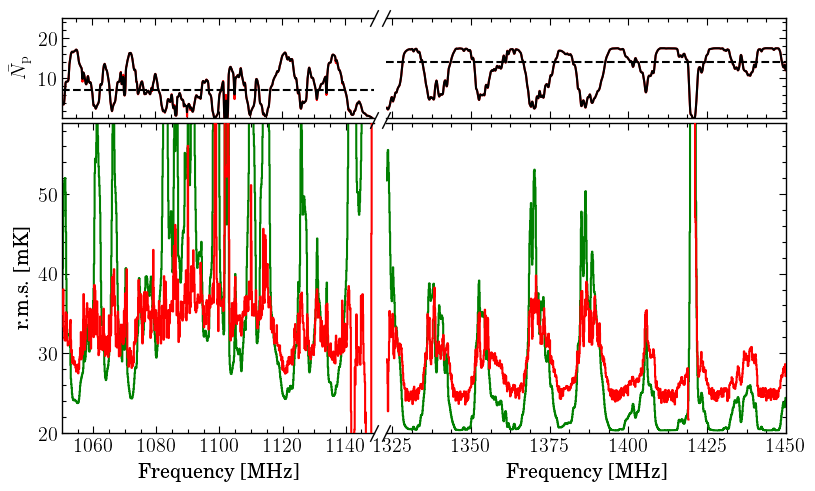

In [64]:
sigma_freq_list = [sigma_freq_l_list[:, 0], sigma_freq_h_list[:, 0]]
hit_freq_list = [hit_freq_list_l, hit_freq_list_h]
freq = [freq_l, freq_h]

Tsys = [23.18, 20.03]
plot_rms_freq(sigma_freq_list, freq, hit_freq_list, Tsys=Tsys)

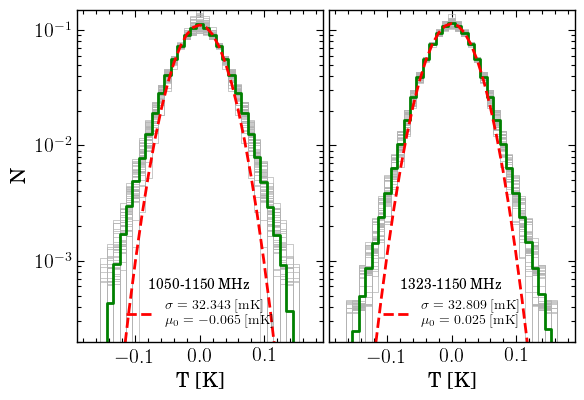

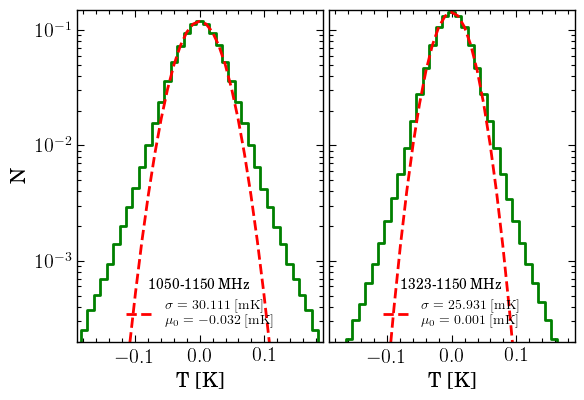

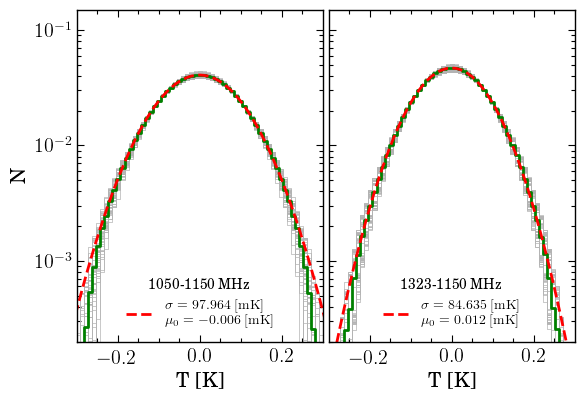

In [349]:
hist_tod_l_combine_beam = np.sum(hist_tod_l, axis=1)
hist_tod_h_combine_beam = np.sum(hist_tod_h, axis=1)

plot_rms_hist_low_and_high_band(hist_map_l, hist_map_h, bc_map_l, bc_map_h, 
                                output_name='map_rms_hist_perblock.png')
plot_rms_hist_low_and_high_band(hist_map1_l[None, :], hist_map1_h[None, :], 
                                bc_map1_l, bc_map1_h, 
                                output_name='map_rms_hist_combine_allfreq.png')

plot_rms_hist_low_and_high_band(hist_tod_l_combine_beam, hist_tod_h_combine_beam, bc, bc,
                               xlim=(-0.3, 0.3), output_name='tod_rms_hist_combine.png')
print

In [381]:
print 32.e-3 * (2 * 1. * 28e3 * 7)**0.5
print 97.e-3 * (2 * 1. * 28e3 )**0.5
print 
print 24.e-3 * (2 * 1. * 28e3 * 14)**0.5
print 84.e-3 * (2 * 1. * 28e3 )**0.5

20.0351690784
22.9543895584

21.2505058763
19.8780280712


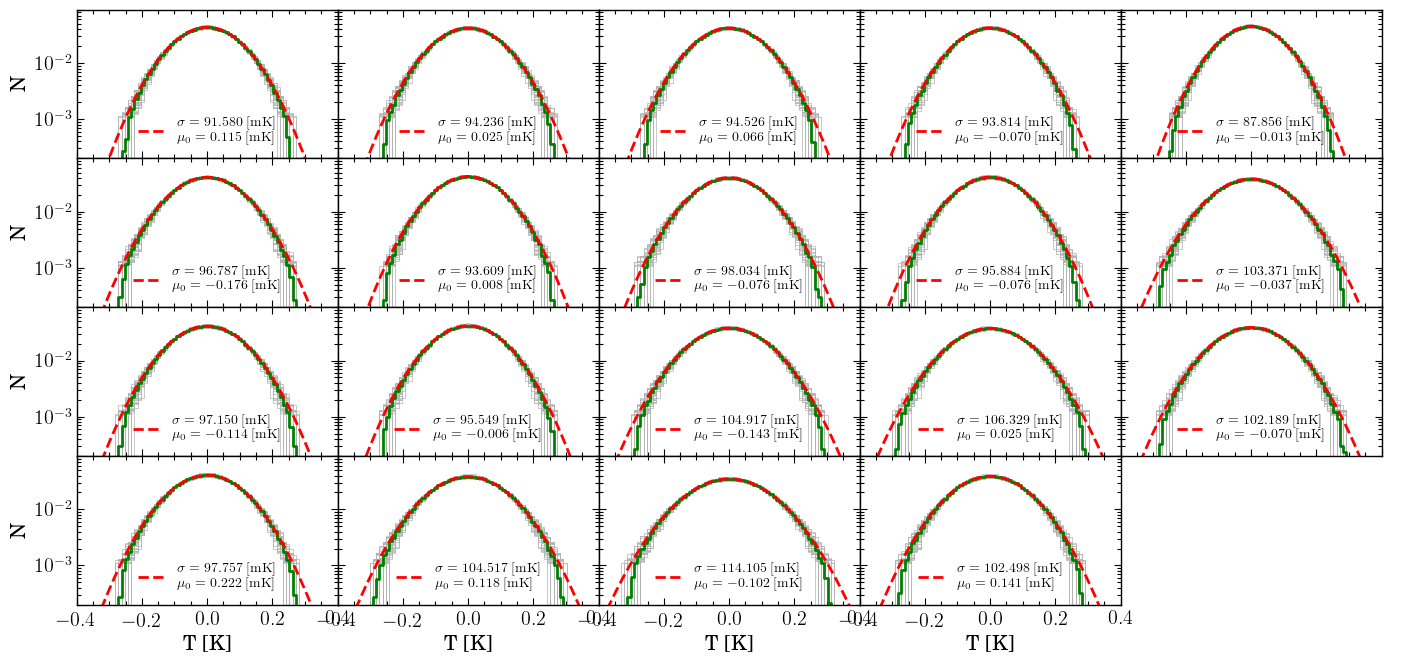

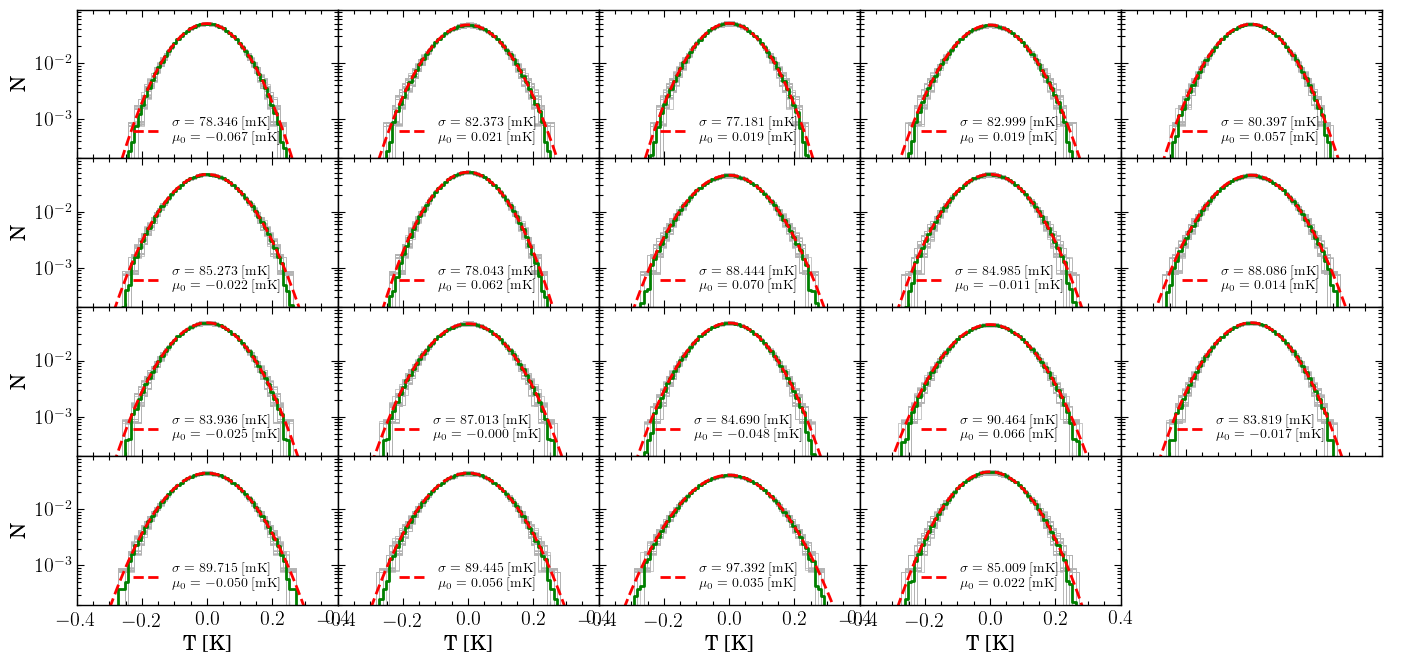

In [188]:
plot_rms_all_beam(hist_tod_l, bc)
plot_rms_all_beam(hist_tod_h, bc)